In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

from pandas.io.json import json_normalize
import json
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report

In [2]:
def load_df(csv_path='data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    p = 0.1
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     skiprows=lambda i: i>0 and random.random() > p)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["{}.{}".format(column, subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print("Loaded {}. Shape: {}".format(os.path.basename(csv_path), df.shape))
    return df

In [3]:
train_data = load_df()
test_data = load_df('data/test.csv')

Loaded train.csv. Shape: (90666, 54)
Loaded test.csv. Shape: (79785, 53)


In [4]:
train_data.shape
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90666 entries, 0 to 90665
Data columns (total 54 columns):
channelGrouping                                      90666 non-null object
date                                                 90666 non-null int64
fullVisitorId                                        90666 non-null object
sessionId                                            90666 non-null object
socialEngagementType                                 90666 non-null object
visitId                                              90666 non-null int64
visitNumber                                          90666 non-null int64
visitStartTime                                       90666 non-null int64
device.browser                                       90666 non-null object
device.browserSize                                   90666 non-null object
device.browserVersion                                90666 non-null object
device.deviceCategory                                90666 non-null ob

In [5]:
shops_or_not = lambda x : x.total

In [6]:
train_data['fullVisitorId'].nunique()

85976

In [7]:
train_data["totals.transactionRevenue"] = train_data["totals.transactionRevenue"].astype('float')
y_clf = (train_data['totals.transactionRevenue'].fillna(0) > 0).astype(np.uint8)
y_reg = train_data['totals.transactionRevenue'].fillna(0)

In [8]:
y_clf.describe()
y_clf.value_counts()

0    89536
1     1130
Name: totals.transactionRevenue, dtype: int64

In [9]:
y_reg.describe()
# y_reg.value_counts()

count    9.066600e+04
mean     1.517437e+06
std      3.081595e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.280700e+09
Name: totals.transactionRevenue, dtype: float64

In [10]:
def date_format(df):
    df['date'] = pd.to_datetime(df['date'])
    df['vis_date'] = pd.to_datetime(df['visitStartTime'])
    df['sess_date_dow'] = df['vis_date'].dt.dayofweek
    df['sess_date_hours'] = df['vis_date'].dt.hour
    df['sess_date_dom'] = df['vis_date'].dt.day
date_format(train_data)
date_format(test_data)

In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79785 entries, 0 to 79784
Data columns (total 57 columns):
channelGrouping                                      79785 non-null object
date                                                 79785 non-null datetime64[ns]
fullVisitorId                                        79785 non-null object
sessionId                                            79785 non-null object
socialEngagementType                                 79785 non-null object
visitId                                              79785 non-null int64
visitNumber                                          79785 non-null int64
visitStartTime                                       79785 non-null int64
device.browser                                       79785 non-null object
device.browserSize                                   79785 non-null object
device.browserVersion                                79785 non-null object
device.deviceCategory                                79785 no

In [12]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'non_zero_proba', 'vis_date'
]

categorical_features = [
    _f for _f in train_data.columns
    if (_f not in excluded_features) & (train_data[_f].dtype == 'object')
]

In [13]:
if 'totals.transactionRevenue' in train_data.columns:
    del train_data['totals.transactionRevenue']

if 'totals.transactionRevenue' in test_data.columns:
    del test_data['totals.transactionRevenue']

In [14]:
for f in categorical_features:
    train_data[f], indexer = pd.factorize(train_data[f])
    test_data[f] = indexer.get_indexer(test_data[f])

In [19]:
import lightgbm as lgb
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss, roc_curve, precision_recall_curve

folds = GroupKFold(n_splits=5)

train_features = [_f for _f in train_data.columns if _f not in excluded_features]
print(train_features)
oof_clf_preds = np.zeros(train_data.shape[0])
sub_clf_preds = np.zeros(test_data.shape[0])
for fold_, (trn_, val_) in enumerate(folds.split(y_clf, y_clf, groups=train_data['fullVisitorId'])):
    trn_x, trn_y = train_data[train_features].iloc[trn_], y_clf.iloc[trn_]
    val_x, val_y = train_data[train_features].iloc[val_], y_clf.iloc[val_]
    
    clf = lgb.LGBMClassifier(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    clf.fit(
        trn_x, trn_y,
        eval_set=[(val_x, val_y)],
        early_stopping_rounds=50,
        verbose=50
    )
    
    oof_clf_preds[val_] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    print(roc_auc_score(val_y, oof_clf_preds[val_]))
    sub_clf_preds += clf.predict_proba(test_data[train_features], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits




['channelGrouping', 'socialEngagementType', 'visitNumber', 'device.browser', 'device.browserSize', 'device.browserVersion', 'device.deviceCategory', 'device.flashVersion', 'device.isMobile', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystem', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.city', 'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.networkLocation', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'totals.visits', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.adwordsClickInfo.gclId', 'trafficSour

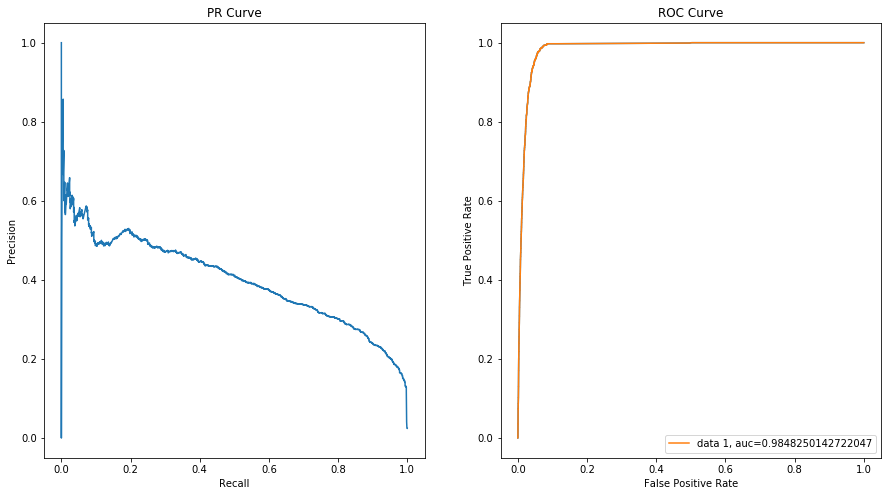

No handles with labels found to put in legend.


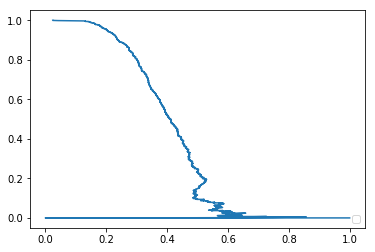

In [26]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')


fpr, tpr, _ = roc_curve(y_clf,  oof_clf_preds)    
auc = roc_auc_score(y_clf, oof_clf_preds)
p,r,_ = precision_recall_curve(y_clf,oof_clf_preds)

ax1.plot(r,p)
ax2.plot(fpr, tpr)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

plt.plot(p,r)
plt.legend(loc=4)
plt.show()

In [ ]:
oof_clf_preds.shape

In [ ]:
sum(oof_clf_preds)

In [ ]:
print(classification_report(y_clf, oof_clf_preds))

In [ ]:
from scipy import stats

In [ ]:
print(stats.describe(oof_clf_preds))

In [ ]:
oof_clf_preds.min()

In [ ]:
oof_clf_preds.max()

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_clf, oof_clf_preds)

In [ ]:
train_data['non_zero_proba'] = oof_clf_preds
test_data['non_zero_proba'] = sub_clf_preds

In [ ]:
train_features = [_f for _f in train_data.columns if _f not in excluded_features] + ['non_zero_proba']
print(train_features)

oof_reg_preds = np.zeros(train_data.shape[0])
sub_reg_preds = np.zeros(test_data.shape[0])
importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds.split(y_reg, y_reg, groups=train_data['fullVisitorId'])):
    trn_x, trn_y = train_data[train_features].iloc[trn_], y_reg.iloc[trn_].fillna(0)
    val_x, val_y = train_data[train_features].iloc[val_], y_reg.iloc[val_].fillna(0)
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=50
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test_data[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / folds.n_splits
    
mean_squared_error(np.log1p(y_reg.fillna(0)), oof_reg_preds) ** .5

In [ ]:
imp_df

In [ ]:
importances

In [ ]:
importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))